In [1]:
import numpy as np
import os, shutil, glob, tempfile, gc
import math, random
from datetime import datetime
import PIL
import PIL.Image
import tensorflow as tf

from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

mos_img_dir = './datasets/ParkDatasets/ParkDatasetAug'
class_names = ['Aedes albopictus', 'Aedes vexans', 'Anopheles sinensis', 'Culex pipiens', 'Culex tritaeniorhynchus', 'Non vectors']

SDO = 0.2

NUM_EPOCH_PER_TRAIN = 40

BATCH_SIZE = 8

# initial value of learning rate
LR = 2e-5
# multiplier factor
LR_MULTIPLIER = 0.5
# number of epochs per reduction
NUM_EPOCH_PER_LR_UPDATE = 10

# original image size
IMG_SIZE = 224

# ratio of (train, val, test)
RATIO = (0.80, 0.2, 0) # train, val, test -> We don't need test = val

# Function to callback every beginning of each epoch
# Learning rate adaptation
def lr_scheduler(epoch, lr):
    return lr * LR_MULTIPLIER if (epoch % NUM_EPOCH_PER_LR_UPDATE) == 0 else lr

lr_adjust = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
# Early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', baseline=0.2,  min_delta = 0.0001, 
                               patience=15, restore_best_weights = True)


2022-09-23 00:05:09.323619: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
from keras import initializers, Input, layers
# from tensorflow.keras.utils import Sequence
# from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Flatten, Conv2D, Concatenate, Dropout, SpatialDropout2D, SpatialDropout1D, MaxPool2D, Add


In [3]:
def buildSDModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0)
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)

    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2)
    spa_1 = SpatialDropout2D(SDO)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(SDO)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)
    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3)
    spa_3 = SpatialDropout2D(SDO)(maxpool_3)
    block4_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(SDO)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block5_conv3)
    spa_5 = SpatialDropout2D(SDO)(maxpool_5)
    flat = Flatten()(spa_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(6, activation='softmax')(drop_2)
    model = Model(inputs=input0, outputs=output)
    return model

In [4]:
def loadVGG16ImageNetWeightsSD(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[1].set_weights(layer.get_weights()),
        elif layer.name == 'block1_conv2': 
            model.layers[2].set_weights(layer.get_weights()),
        elif layer.name == 'block2_conv1': 
            model.layers[5].set_weights(layer.get_weights()) 
        elif layer.name == 'block2_conv2': 
            model.layers[6].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[9].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[10].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[11].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[14].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[15].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[16].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[20].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[21].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[25].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[27].set_weights(layer.get_weights())
    return model


In [5]:
def between0i1x(f):
    if 0 <= f < 1:
        return True
    else:
        return False
    

In [6]:
def RandomTrainValTest(src_dir, dst_dir, ratio = (0.8, 0.2, 0)):
    #check if Destination directory already exists
    if os.path.exists(dst_dir):
        print('Destination directory already exists. Do nothing!!!')
        return
    TRAIN_RATIO = round(ratio[0], 3)
    VAL_RATIO = round(ratio[1], 3)
    TEST_RATIO = round(1 - TRAIN_RATIO - VAL_RATIO, 3)
    if not between0i1x(TEST_RATIO) or not between0i1x(VAL_RATIO) or not between0i1x(TRAIN_RATIO):
        print('Ratio must be more than or equal 0 and less than 1.')
        return
    print('Ratio = (' + str(TRAIN_RATIO) +', ' + str(VAL_RATIO) + ', ' + str(TEST_RATIO) + ').' )
    if TEST_RATIO != round(ratio[2],3):
        print('Sum of ratio must be 1.')
        return
    
    # create a temp dir and copy all files recursively to temp_dir
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)
    # scan species, they must be immediatly under the src_dir 
    for species in os.scandir(src_dir):
        if not species.name.startswith('.') and species.is_dir():
            class_dir = tmp_dir + '/' + species.name
            print('Found ' + species.name)
            #calculate No. of files in each species 
            file_no = 0
            for entry2 in os.scandir(class_dir):
                if not entry2.name.startswith('.') and entry2.is_file():
                    file_no += 1
            print('No. of files in ' + species.name + ' = ' + str(file_no) + '.')
            # create subdirectories if necessary
            if not os.path.exists(dst_dir):
                os.mkdir(dst_dir)
            test_dir = dst_dir + '/test/' 
            val_dir = dst_dir + '/val/' 
            train_dir = dst_dir + '/train/' 
            if not os.path.exists(test_dir):
                os.mkdir(test_dir)
            if not os.path.exists(val_dir):
                os.mkdir(val_dir)
            if not os.path.exists(train_dir):
                os.mkdir(train_dir)
            # create species.name dir    
            stest_dir = test_dir + species.name + '/'
            sval_dir = val_dir + species.name + '/'
            strain_dir = train_dir + species.name + '/'
            if not os.path.exists(stest_dir):
                os.mkdir(stest_dir)
            if not os.path.exists(sval_dir):
                os.mkdir(sval_dir)
            if not os.path.exists(strain_dir):
                os.mkdir(strain_dir)
            # calculate number of files for train, val, test    
            no_file_train = math.ceil(file_no*TRAIN_RATIO)
            no_file_val = math.ceil(file_no*VAL_RATIO)
            no_file_test = math.ceil(file_no*TEST_RATIO)
            
            # for training data
            file_no = 0
            while file_no < no_file_train : 
                selectedFile = random.choice(os.listdir(tmp_dir + '/' + species.name))
                # find index no
                no = selectedFile.rfind('_') 
                # select all files that have the same index no.
                SelectedFiles = '*' + selectedFile[no:] 
                # move all the selected files
                file_moved = 0
                for file in glob.iglob(class_dir +'/'+ SelectedFiles, recursive=True):    
                    file_name = os.path.basename(file)
                    shutil.move(file, strain_dir + file_name)
                    file_moved += 1
                # sum file_moved to file_no    
                file_no += file_moved
            print('No. of files in "' + strain_dir + '" should be around ' + str(no_file_train) + '.')
            print('No. of files in ' +strain_dir + ' = ' + str(file_no) +'.' )
            
            # for test data
            file_no = 0
            while file_no < no_file_test and os.listdir(tmp_dir + '/' + species.name): 
                selectedFile = random.choice(os.listdir(tmp_dir + '/' + species.name))
                # find index no
                no = selectedFile.rfind('_') 
                # select all files that have the same index no.
                SelectedFiles = '*' + selectedFile[no:] 
                # move all the selected files
                file_moved = 0
                for file in glob.iglob(class_dir +'/'+ SelectedFiles, recursive=True):    
                    file_name = os.path.basename(file)
                    shutil.move(file, strain_dir + file_name)
                    file_moved += 1
                # sum file_moved to file_no    
                file_no += file_moved
            print('No. of files in "' + stest_dir + '" should be around ' + str(no_file_test) + '.')
            print('No. of files in ' +stest_dir + ' = ' + str(file_no) +'.' )
            #move all remaining files to val_dir
            SelectedFiles = '*'
            file_moved = 0
            for file in glob.iglob(class_dir +'/'+ SelectedFiles, recursive=True):    
                file_name = os.path.basename(file)
                shutil.move(file, sval_dir + file_name)
                file_moved += 1
            file_no = file_moved    
            print('No. of files in "' + sval_dir + '" should be around ' + str(no_file_val) + '.')
            print('No. of files in ' +sval_dir + ' = ' + str(file_no) +'.' )

In [7]:
def read_ds(src_dir):
    
    train_dir = src_dir  + '/train'
    val_dir = src_dir    + '/val'
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
      train_dir,
      #validation_split=0.2,
      #subset="training",
      seed=123,
      image_size=(IMG_SIZE, IMG_SIZE),
      shuffle = False,
      label_mode='categorical',
      batch_size=BATCH_SIZE)

    val_ds = tf.keras.utils.image_dataset_from_directory(
      val_dir,
      #validation_split=0.2,
      #subset="validation",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)



    return (train_ds, val_ds)



In [8]:
def preprocessDS(train_ds, val_ds):
    train_num_batch = sum(1 for _ in train_ds)
    val_num_batch = sum(1 for _ in val_ds)

    # Normalize to (0-1)
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))




    # Load the dataset onto GPU RAM for superspeed
    train_ds = train_ds.cache()
    val_ds = val_ds.cache()

    # reshuffle the train ds every batch (second times onwords in GPU), but shuffle val ds only once
    train_ds = train_ds.shuffle(train_num_batch, reshuffle_each_iteration=True)
    val_ds   = val_ds.shuffle(val_num_batch, reshuffle_each_iteration=False)


    # prefetch the datasets for lower latency
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

    return (train_ds, val_ds)
    #...

In [9]:
def compileModel(model):
    # Optimizer hyperparameter
    myAdam = keras.optimizers.Adam(
        learning_rate=LR/LR_MULTIPLIER,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=0.0001,
        amsgrad=True,
        name="Adam",)

    model.compile(optimizer=myAdam,
              loss=tf.keras.losses.CategoricalCrossentropy(
                    from_logits=False,
                    label_smoothing=0.0,
                    axis=-1,
                    reduction="auto",
                    name="categorical_crossentropy"),
              metrics=['accuracy'])
    return model


In [10]:
def fitModel(model, train_ds, val_ds, lr_adjust = None, early_stopping = None):
    print('Start fitting from ' + datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
    history = model.fit(train_ds,    
                  epochs=NUM_EPOCH_PER_TRAIN,   
                  validation_data = val_ds,
                  callbacks=[lr_adjust, early_stopping])
    print('End fitting at '+ datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
    return history

In [11]:
def plotAccuracyLoss(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    #epochs_range = range(epochs)
    epochs_range = range(len(loss))
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [12]:
def printConfusionMatrix(model, ds):
    #Confution Matrix and Classification Report

    Y_pred = model.predict(ds)
    y_pred = np.argmax(Y_pred, axis=1)
    Y_true = np.concatenate([y for x, y in ds], axis=0)
    y_true = np.argmax(Y_true, axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(y_true, y_pred))
    print('')
    print('')
    print('Classification Report')

    print(classification_report(y_true, y_pred, target_names=class_names))


In [13]:
def saveSDOModel(model):
    path = './models/Model_SDO_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path

In [14]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmphv5t56_t/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmphv5t56_t/train/Aedes vexans/ = 4726.
No. of files in "/tmp/tmphv5t56_t/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmphv5t56_t/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmphv5t56_t/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmphv5t56_t/val/Aedes vexans/ = 1175.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmphv5t56_t/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmphv5t56_t/train/Anopheles sinensis/ = 4745.
No. of files in "/tmp/tmphv5t56_t/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmphv5t56_t/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmphv5t56_t/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmphv5t56_t/val/Anopheles sinensis/ = 1178.
Foun

In [15]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)

Found 28655 files belonging to 6 classes.


2022-09-23 00:05:22.714332: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-23 00:05:23.588302: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22227 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


Found 7085 files belonging to 6 classes.


In [16]:
model = buildSDModel()
model.summary()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img0 (InputLayer)           [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 spatial_dropout2d (SpatialD  (None, 112, 112, 64)     0         
 ropout2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856 

In [17]:
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
maxAcc = np.max(fitHistory.history['val_accuracy'])

Start fitting from 2022/09/23-00:05:31

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40


2022-09-23 00:05:38.305175: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-09-23 00:05:41.128659: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3582/3582 [==============================] - 245s 65ms/step - loss: 1.6153 - accuracy: 0.3071 - val_loss: 1.0582 - val_accuracy: 0.5188 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3582/3582 [==============================] - 228s 64ms/step - loss: 0.7456 - accuracy: 0.7091 - val_loss: 0.3339 - val_accuracy: 0.8840 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3582/3582 [==============================] - 222s 62ms/step - loss: 0.2923 - accuracy: 0.8946 - val_loss: 0.2584 - val_accuracy: 0.9011 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3582/3582 [==============================] - 222s 62ms/step - loss: 0.1580 - accuracy: 0.9446 - val_loss: 0.1270 - val_accuracy: 0.9598 - lr: 2.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 5/40
3582/3582 [=========

Maximum test accuracy is at 98.17 %.


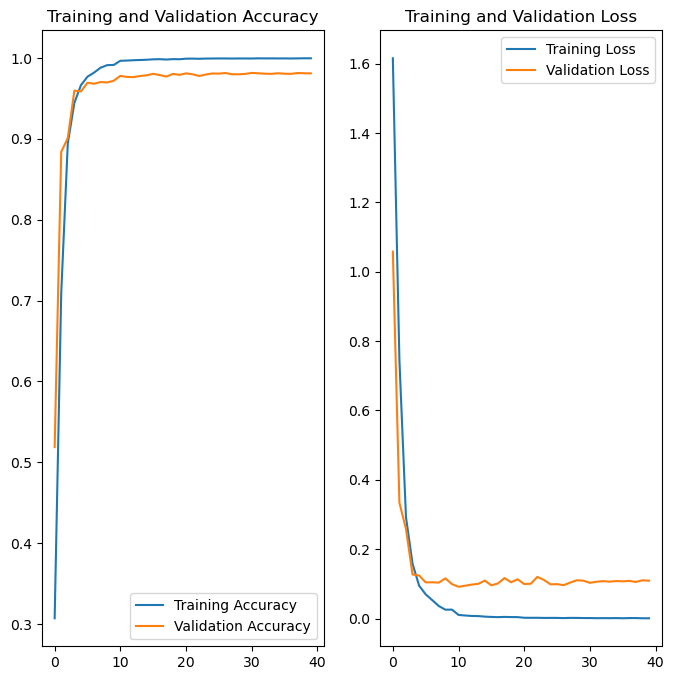

In [18]:
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)

In [22]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

886/886 [==============================] - 15s 17ms/step
Confusion Matrix
[[1157    0    0    3    0   25]
 [   0 1138    3    0   29    5]
 [   0    8 1156    0    1   13]
 [   0    0    0 1185    0    0]
 [   4   28    0    0 1146    0]
 [   4    6    0    4    1 1169]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.99      0.98      0.98      1185
           Aedes vexans       0.96      0.97      0.97      1175
     Anopheles sinensis       1.00      0.98      0.99      1178
          Culex pipiens       0.99      1.00      1.00      1185
Culex tritaeniorhynchus       0.97      0.97      0.97      1178
            Non vectors       0.96      0.99      0.98      1184

               accuracy                           0.98      7085
              macro avg       0.98      0.98      0.98      7085
           weighted avg       0.98      0.98      0.98      7085

Model is saved in ./models/Model_SDO_Park_2022-09-

In [23]:
#-----Run 2

In [24]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))
#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmpsl024ajt/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmpsl024ajt/train/Aedes vexans/ = 4739.
No. of files in "/tmp/tmpsl024ajt/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmpsl024ajt/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmpsl024ajt/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmpsl024ajt/val/Aedes vexans/ = 1162.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmpsl024ajt/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmpsl024ajt/train/Anopheles sinensis/ = 4749.
No. of files in "/tmp/tmpsl024ajt/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmpsl024ajt/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmpsl024ajt/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmpsl024ajt/val/Anopheles sinensis/ = 1174.
Foun

In [25]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28695 files belonging to 6 classes.
Found 7045 files belonging to 6 classes.


In [26]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/23-08:15:23

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3587/3587 [==============================] - 226s 61ms/step - loss: 1.6174 - accuracy: 0.2990 - val_loss: 1.0546 - val_accuracy: 0.5568 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3587/3587 [==============================] - 221s 62ms/step - loss: 0.8544 - accuracy: 0.6609 - val_loss: 0.5386 - val_accuracy: 0.7966 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3587/3587 [==============================] - 223s 62ms/step - loss: 0.3768 - accuracy: 0.8597 - val_loss: 0.2082 - val_accuracy: 0.9270 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3587/3587 [==============================] - 223s 62ms/step - loss: 0.1863 - accuracy: 0.9330 - val_loss: 0.1464 - val_accuracy: 0.947

Maximum test accuracy is at 98.48 %.


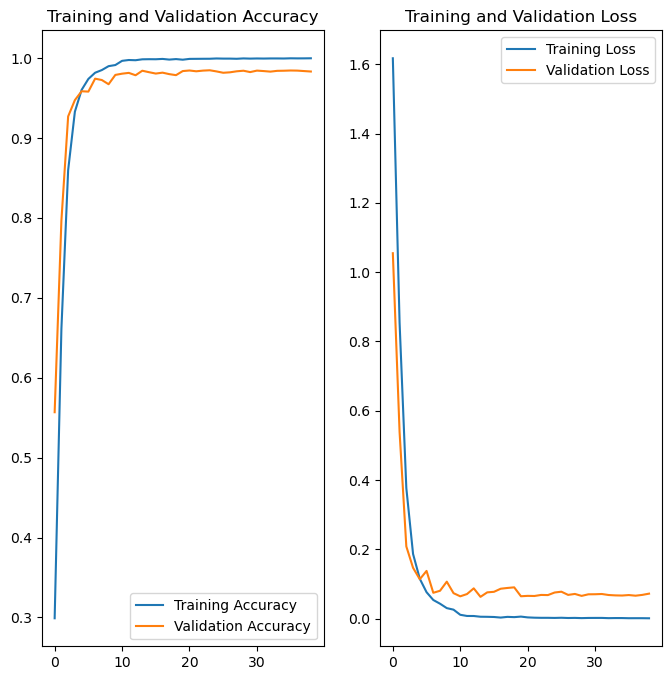

In [27]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [28]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

881/881 [==============================] - 14s 16ms/step
Confusion Matrix
[[1186    0    0    1    0    7]
 [   0 1142    3    5    8    4]
 [   1   17 1153    0    0    3]
 [   1    1    1 1184    3    1]
 [   0   12    1    0 1154    0]
 [  12   17    0    7    2 1119]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.99      0.99      0.99      1194
           Aedes vexans       0.96      0.98      0.97      1162
     Anopheles sinensis       1.00      0.98      0.99      1174
          Culex pipiens       0.99      0.99      0.99      1191
Culex tritaeniorhynchus       0.99      0.99      0.99      1167
            Non vectors       0.99      0.97      0.98      1157

               accuracy                           0.98      7045
              macro avg       0.98      0.98      0.98      7045
           weighted avg       0.98      0.98      0.98      7045

Model is saved in ./models/Model_SDO_Park_2022-09-

In [29]:
#-----Run 3

In [30]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))
#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmpc_6r1tbe/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmpc_6r1tbe/train/Aedes vexans/ = 4721.
No. of files in "/tmp/tmpc_6r1tbe/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmpc_6r1tbe/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmpc_6r1tbe/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmpc_6r1tbe/val/Aedes vexans/ = 1180.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmpc_6r1tbe/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmpc_6r1tbe/train/Anopheles sinensis/ = 4742.
No. of files in "/tmp/tmpc_6r1tbe/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmpc_6r1tbe/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmpc_6r1tbe/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmpc_6r1tbe/val/Anopheles sinensis/ = 1181.
Foun

In [31]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28651 files belonging to 6 classes.
Found 7089 files belonging to 6 classes.


In [32]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/23-10:31:21

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3582/3582 [==============================] - 213s 57ms/step - loss: 1.4292 - accuracy: 0.3944 - val_loss: 0.8231 - val_accuracy: 0.6833 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3582/3582 [==============================] - 206s 58ms/step - loss: 0.5627 - accuracy: 0.7907 - val_loss: 0.2581 - val_accuracy: 0.9076 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3582/3582 [==============================] - 203s 57ms/step - loss: 0.2336 - accuracy: 0.9165 - val_loss: 0.1803 - val_accuracy: 0.9408 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3582/3582 [==============================] - 205s 57ms/step - loss: 0.1238 - accuracy: 0.9572 - val_loss: 0.1512 - val_accuracy: 0.950

Maximum test accuracy is at 98.29 %.


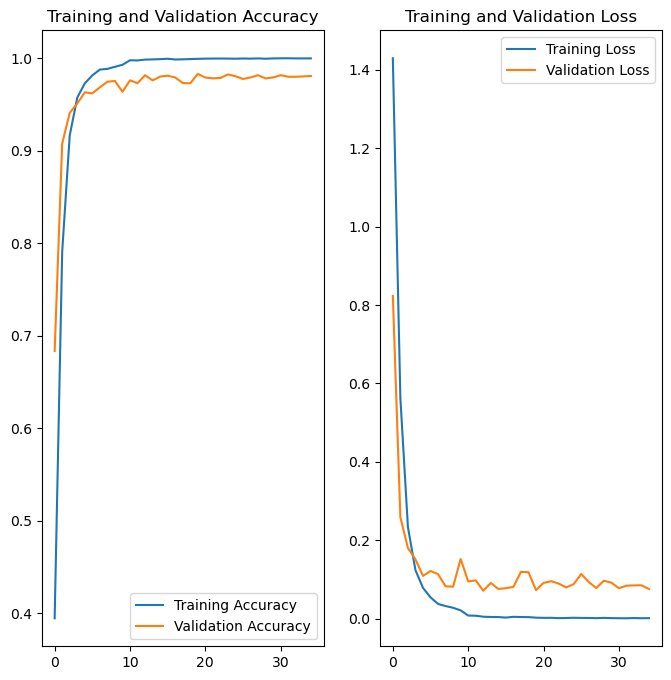

In [33]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [34]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

887/887 [==============================] - 14s 15ms/step
Confusion Matrix
[[1171   16    0    2    0    3]
 [   0 1150    3    0   14   13]
 [   2   12 1164    0    0    3]
 [   1    0    0 1188    1    1]
 [   0   12    0    0 1155    0]
 [   5   10    2   12    9 1140]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.99      0.98      0.99      1192
           Aedes vexans       0.96      0.97      0.97      1180
     Anopheles sinensis       1.00      0.99      0.99      1181
          Culex pipiens       0.99      1.00      0.99      1191
Culex tritaeniorhynchus       0.98      0.99      0.98      1167
            Non vectors       0.98      0.97      0.98      1178

               accuracy                           0.98      7089
              macro avg       0.98      0.98      0.98      7089
           weighted avg       0.98      0.98      0.98      7089

Model is saved in ./models/Model_SDO_Park_2022-09-

In [35]:
#-----Run 4

In [36]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))
#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmp8jlwp1kf/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmp8jlwp1kf/train/Aedes vexans/ = 4722.
No. of files in "/tmp/tmp8jlwp1kf/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmp8jlwp1kf/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmp8jlwp1kf/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmp8jlwp1kf/val/Aedes vexans/ = 1179.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmp8jlwp1kf/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmp8jlwp1kf/train/Anopheles sinensis/ = 4744.
No. of files in "/tmp/tmp8jlwp1kf/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmp8jlwp1kf/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmp8jlwp1kf/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmp8jlwp1kf/val/Anopheles sinensis/ = 1179.
Foun

In [37]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28656 files belonging to 6 classes.
Found 7084 files belonging to 6 classes.


In [38]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/23-12:29:37

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3582/3582 [==============================] - 208s 56ms/step - loss: 1.5867 - accuracy: 0.3234 - val_loss: 1.0933 - val_accuracy: 0.5590 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3582/3582 [==============================] - 200s 56ms/step - loss: 0.7977 - accuracy: 0.6866 - val_loss: 0.4018 - val_accuracy: 0.8587 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3582/3582 [==============================] - 201s 56ms/step - loss: 0.3384 - accuracy: 0.8736 - val_loss: 0.2732 - val_accuracy: 0.9073 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3582/3582 [==============================] - 200s 56ms/step - loss: 0.1791 - accuracy: 0.9352 - val_loss: 0.1488 - val_accuracy: 0.948

Maximum test accuracy is at 98.74 %.


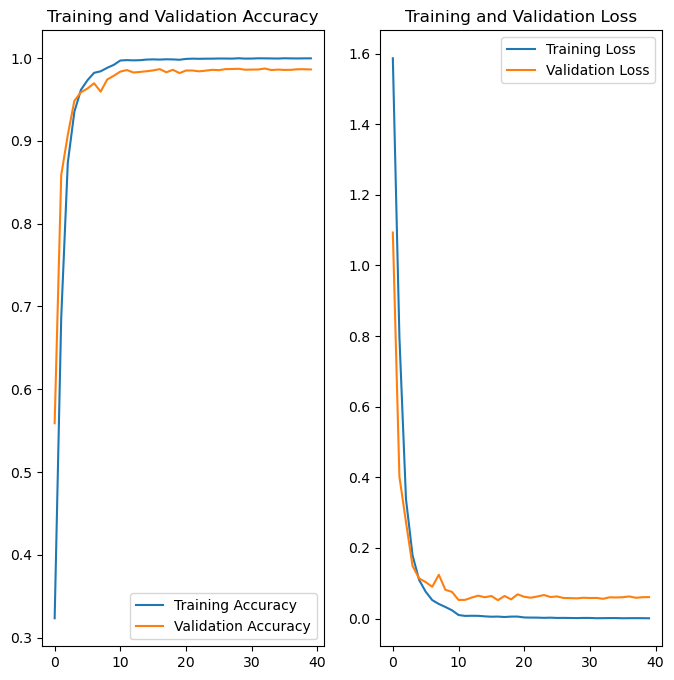

In [39]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [40]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

886/886 [==============================] - 13s 15ms/step
Confusion Matrix
[[1177    0    0    0    0   14]
 [   0 1157    1    0   16    5]
 [   4    7 1167    0    0    1]
 [   1    0    0 1184    0    4]
 [   0   17    0    0 1164    0]
 [  13    7    4    3    0 1138]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.98      0.99      0.99      1191
           Aedes vexans       0.97      0.98      0.98      1179
     Anopheles sinensis       1.00      0.99      0.99      1179
          Culex pipiens       1.00      1.00      1.00      1189
Culex tritaeniorhynchus       0.99      0.99      0.99      1181
            Non vectors       0.98      0.98      0.98      1165

               accuracy                           0.99      7084
              macro avg       0.99      0.99      0.99      7084
           weighted avg       0.99      0.99      0.99      7084

Model is saved in ./models/Model_SDO_Park_2022-09-

In [41]:
#-----Run 5

In [42]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))
#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmpj0xmxhpy/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmpj0xmxhpy/train/Aedes vexans/ = 4730.
No. of files in "/tmp/tmpj0xmxhpy/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmpj0xmxhpy/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmpj0xmxhpy/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmpj0xmxhpy/val/Aedes vexans/ = 1171.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmpj0xmxhpy/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmpj0xmxhpy/train/Anopheles sinensis/ = 4749.
No. of files in "/tmp/tmpj0xmxhpy/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmpj0xmxhpy/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmpj0xmxhpy/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmpj0xmxhpy/val/Anopheles sinensis/ = 1174.
Foun

In [43]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28641 files belonging to 6 classes.
Found 7099 files belonging to 6 classes.


In [44]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/23-14:45:10

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3581/3581 [==============================] - 213s 58ms/step - loss: 1.6048 - accuracy: 0.3125 - val_loss: 1.0172 - val_accuracy: 0.5874 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3581/3581 [==============================] - 204s 57ms/step - loss: 0.7556 - accuracy: 0.7127 - val_loss: 0.4831 - val_accuracy: 0.8160 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3581/3581 [==============================] - 205s 57ms/step - loss: 0.2939 - accuracy: 0.8925 - val_loss: 0.2323 - val_accuracy: 0.9107 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3581/3581 [==============================] - 203s 57ms/step - loss: 0.1558 - accuracy: 0.9448 - val_loss: 0.1782 - val_accuracy: 0.937

Maximum test accuracy is at 98.18 %.


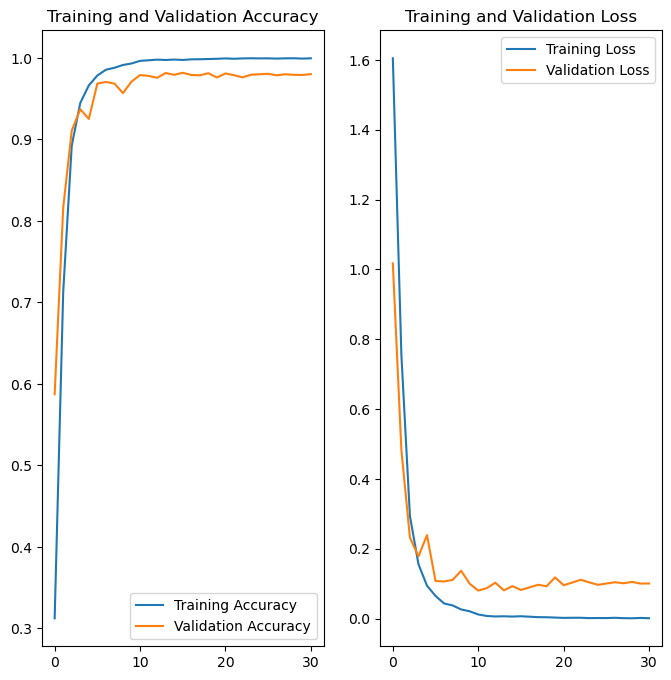

In [45]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [46]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

888/888 [==============================] - 14s 15ms/step
Confusion Matrix
[[1174    1    0    8    3   13]
 [   2 1139    1    0   10   19]
 [   0    1 1158    1    1   13]
 [   0    4    0 1181    5    0]
 [   0   11    0    0 1160    0]
 [   9    7   10    5    5 1158]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.99      0.98      0.98      1199
           Aedes vexans       0.98      0.97      0.98      1171
     Anopheles sinensis       0.99      0.99      0.99      1174
          Culex pipiens       0.99      0.99      0.99      1190
Culex tritaeniorhynchus       0.98      0.99      0.99      1171
            Non vectors       0.96      0.97      0.97      1194

               accuracy                           0.98      7099
              macro avg       0.98      0.98      0.98      7099
           weighted avg       0.98      0.98      0.98      7099

Model is saved in ./models/Model_SDO_Park_2022-09-

In [47]:
#-----Run 6

In [48]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))
#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmpeyet_0g4/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmpeyet_0g4/train/Aedes vexans/ = 4741.
No. of files in "/tmp/tmpeyet_0g4/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmpeyet_0g4/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmpeyet_0g4/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmpeyet_0g4/val/Aedes vexans/ = 1160.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmpeyet_0g4/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmpeyet_0g4/train/Anopheles sinensis/ = 4743.
No. of files in "/tmp/tmpeyet_0g4/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmpeyet_0g4/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmpeyet_0g4/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmpeyet_0g4/val/Anopheles sinensis/ = 1180.
Foun

In [49]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28716 files belonging to 6 classes.
Found 7024 files belonging to 6 classes.


In [50]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/23-21:45:57

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3590/3590 [==============================] - 223s 60ms/step - loss: 1.5681 - accuracy: 0.3272 - val_loss: 1.2726 - val_accuracy: 0.4593 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3590/3590 [==============================] - 206s 57ms/step - loss: 0.7893 - accuracy: 0.6952 - val_loss: 0.4352 - val_accuracy: 0.8387 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3590/3590 [==============================] - 203s 57ms/step - loss: 0.3439 - accuracy: 0.8743 - val_loss: 0.1984 - val_accuracy: 0.9302 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3590/3590 [==============================] - 203s 57ms/step - loss: 0.1846 - accuracy: 0.9339 - val_loss: 0.2694 - val_accuracy: 0.905

Maximum test accuracy is at 98.88 %.


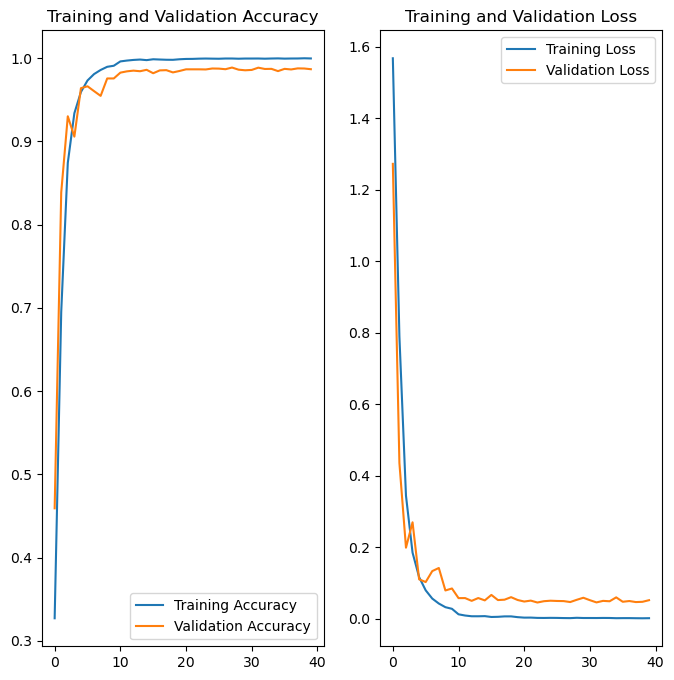

In [51]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [52]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

878/878 [==============================] - 14s 15ms/step
Confusion Matrix
[[1167    1    0    2    0    8]
 [   0 1142    1    6    8    3]
 [   1   13 1164    0    2    0]
 [   1    0    0 1168    0    0]
 [   0   12    1    0 1147    0]
 [   5   18    1    5    5 1143]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.99      0.99      0.99      1178
           Aedes vexans       0.96      0.98      0.97      1160
     Anopheles sinensis       1.00      0.99      0.99      1180
          Culex pipiens       0.99      1.00      0.99      1169
Culex tritaeniorhynchus       0.99      0.99      0.99      1160
            Non vectors       0.99      0.97      0.98      1177

               accuracy                           0.99      7024
              macro avg       0.99      0.99      0.99      7024
           weighted avg       0.99      0.99      0.99      7024

Model is saved in ./models/Model_SDO_Park_2022-09-

In [53]:
#-----Run 7

In [54]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))
#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmp54tr1wg8/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmp54tr1wg8/train/Aedes vexans/ = 4724.
No. of files in "/tmp/tmp54tr1wg8/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmp54tr1wg8/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmp54tr1wg8/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmp54tr1wg8/val/Aedes vexans/ = 1177.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmp54tr1wg8/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmp54tr1wg8/train/Anopheles sinensis/ = 4749.
No. of files in "/tmp/tmp54tr1wg8/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmp54tr1wg8/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmp54tr1wg8/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmp54tr1wg8/val/Anopheles sinensis/ = 1174.
Foun

In [55]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28667 files belonging to 6 classes.
Found 7073 files belonging to 6 classes.


In [56]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/24-00:00:38

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3584/3584 [==============================] - 208s 56ms/step - loss: 1.4539 - accuracy: 0.3926 - val_loss: 0.9439 - val_accuracy: 0.6243 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3584/3584 [==============================] - 207s 58ms/step - loss: 0.6167 - accuracy: 0.7621 - val_loss: 0.2829 - val_accuracy: 0.8910 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3584/3584 [==============================] - 206s 57ms/step - loss: 0.2648 - accuracy: 0.9025 - val_loss: 0.2881 - val_accuracy: 0.8921 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3584/3584 [==============================] - 205s 57ms/step - loss: 0.1405 - accuracy: 0.9514 - val_loss: 0.1840 - val_accuracy: 0.942

Maximum test accuracy is at 98.5 %.


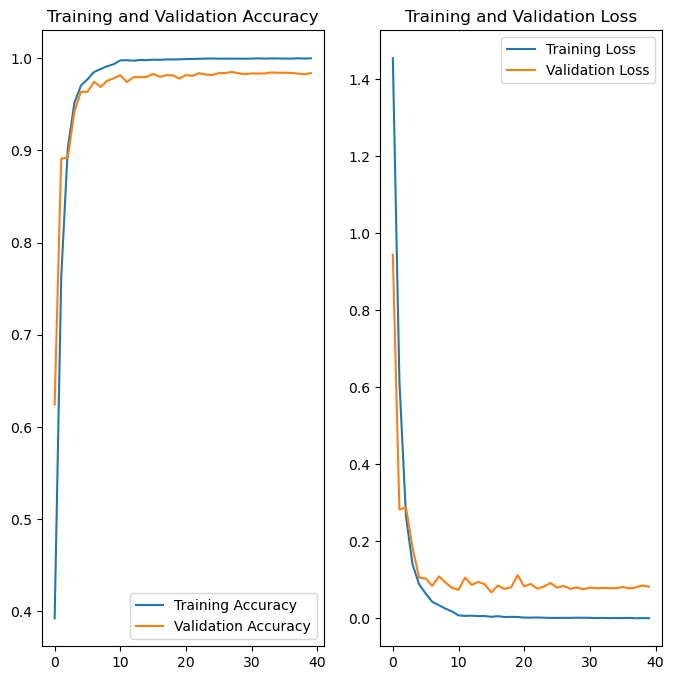

In [57]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [58]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

885/885 [==============================] - 14s 15ms/step
Confusion Matrix
[[1185    2    0    1    4    8]
 [   0 1124    1    4   45    3]
 [   0    3 1168    0    1    2]
 [   0    0    0 1182    0    0]
 [   2   12    0    0 1157    0]
 [   3   11    4    3    5 1143]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      0.99      0.99      1200
           Aedes vexans       0.98      0.95      0.97      1177
     Anopheles sinensis       1.00      0.99      1.00      1174
          Culex pipiens       0.99      1.00      1.00      1182
Culex tritaeniorhynchus       0.95      0.99      0.97      1171
            Non vectors       0.99      0.98      0.98      1169

               accuracy                           0.98      7073
              macro avg       0.98      0.98      0.98      7073
           weighted avg       0.98      0.98      0.98      7073

Model is saved in ./models/Model_SDO_Park_2022-09-

In [59]:
#-----Run 8

In [60]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))
#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmp_r6bl425/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmp_r6bl425/train/Aedes vexans/ = 4722.
No. of files in "/tmp/tmp_r6bl425/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmp_r6bl425/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmp_r6bl425/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmp_r6bl425/val/Aedes vexans/ = 1179.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmp_r6bl425/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmp_r6bl425/train/Anopheles sinensis/ = 4741.
No. of files in "/tmp/tmp_r6bl425/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmp_r6bl425/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmp_r6bl425/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmp_r6bl425/val/Anopheles sinensis/ = 1182.
Foun

In [61]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28648 files belonging to 6 classes.
Found 7092 files belonging to 6 classes.


In [62]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/24-02:17:05

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3581/3581 [==============================] - 217s 59ms/step - loss: 1.5047 - accuracy: 0.3622 - val_loss: 0.8855 - val_accuracy: 0.6868 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3581/3581 [==============================] - 208s 58ms/step - loss: 0.6575 - accuracy: 0.7496 - val_loss: 0.3899 - val_accuracy: 0.8645 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3581/3581 [==============================] - 204s 57ms/step - loss: 0.2687 - accuracy: 0.9032 - val_loss: 0.4775 - val_accuracy: 0.8555 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3581/3581 [==============================] - 205s 57ms/step - loss: 0.1396 - accuracy: 0.9507 - val_loss: 0.1149 - val_accuracy: 0.962

Maximum test accuracy is at 98.52 %.


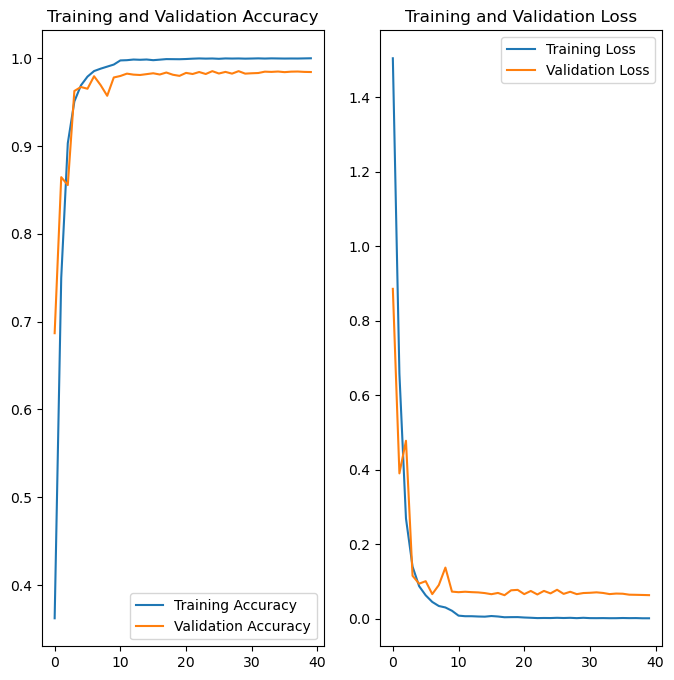

In [63]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [64]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

887/887 [==============================] - 14s 15ms/step
Confusion Matrix
[[1152    1    1    3    2   10]
 [   1 1157    0    0   17    4]
 [   0   18 1164    0    0    0]
 [   1    0    0 1184    0    0]
 [   0   21    0    0 1164    0]
 [   5   11    3    2    5 1166]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.99      0.99      0.99      1169
           Aedes vexans       0.96      0.98      0.97      1179
     Anopheles sinensis       1.00      0.98      0.99      1182
          Culex pipiens       1.00      1.00      1.00      1185
Culex tritaeniorhynchus       0.98      0.98      0.98      1185
            Non vectors       0.99      0.98      0.98      1192

               accuracy                           0.99      7092
              macro avg       0.99      0.99      0.99      7092
           weighted avg       0.99      0.99      0.99      7092

Model is saved in ./models/Model_SDO_Park_2022-09-

In [65]:
#-----Run 9

In [66]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))
#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmpb2i2yf_0/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmpb2i2yf_0/train/Aedes vexans/ = 4736.
No. of files in "/tmp/tmpb2i2yf_0/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmpb2i2yf_0/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmpb2i2yf_0/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmpb2i2yf_0/val/Aedes vexans/ = 1165.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmpb2i2yf_0/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmpb2i2yf_0/train/Anopheles sinensis/ = 4739.
No. of files in "/tmp/tmpb2i2yf_0/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmpb2i2yf_0/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmpb2i2yf_0/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmpb2i2yf_0/val/Anopheles sinensis/ = 1184.
Foun

In [67]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28690 files belonging to 6 classes.
Found 7050 files belonging to 6 classes.


In [68]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/24-04:33:39

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3587/3587 [==============================] - 210s 57ms/step - loss: 1.6314 - accuracy: 0.2883 - val_loss: 1.0623 - val_accuracy: 0.5810 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3587/3587 [==============================] - 200s 56ms/step - loss: 0.8762 - accuracy: 0.6530 - val_loss: 0.4587 - val_accuracy: 0.8227 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3587/3587 [==============================] - 203s 57ms/step - loss: 0.3703 - accuracy: 0.8632 - val_loss: 0.4718 - val_accuracy: 0.8125 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3587/3587 [==============================] - 205s 57ms/step - loss: 0.2102 - accuracy: 0.9257 - val_loss: 0.1901 - val_accuracy: 0.934

Maximum test accuracy is at 98.67 %.


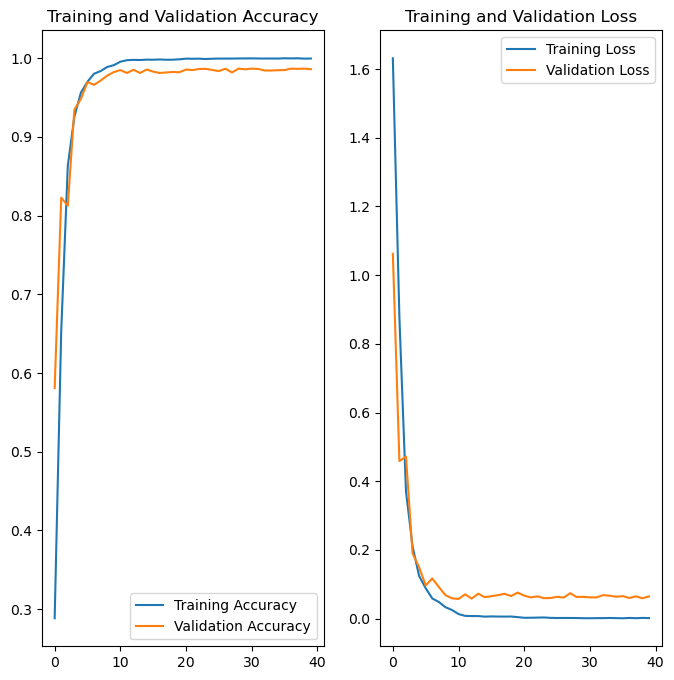

In [69]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [70]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

882/882 [==============================] - 14s 15ms/step
Confusion Matrix
[[1170    2    0    1    0   16]
 [   0 1132    0    0   22   11]
 [   0    0 1184    0    0    0]
 [   0    0    0 1194    0    0]
 [   1    7    0    0 1170    0]
 [   5   13    8   12    1 1101]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.99      0.98      0.99      1189
           Aedes vexans       0.98      0.97      0.98      1165
     Anopheles sinensis       0.99      1.00      1.00      1184
          Culex pipiens       0.99      1.00      0.99      1194
Culex tritaeniorhynchus       0.98      0.99      0.99      1178
            Non vectors       0.98      0.97      0.97      1140

               accuracy                           0.99      7050
              macro avg       0.99      0.99      0.99      7050
           weighted avg       0.99      0.99      0.99      7050

Model is saved in ./models/Model_SDO_Park_2022-09-

In [71]:
#-----Run 10

In [72]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))

#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmpgx_ca3pe/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmpgx_ca3pe/train/Aedes vexans/ = 4722.
No. of files in "/tmp/tmpgx_ca3pe/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmpgx_ca3pe/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmpgx_ca3pe/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmpgx_ca3pe/val/Aedes vexans/ = 1179.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmpgx_ca3pe/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmpgx_ca3pe/train/Anopheles sinensis/ = 4751.
No. of files in "/tmp/tmpgx_ca3pe/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmpgx_ca3pe/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmpgx_ca3pe/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmpgx_ca3pe/val/Anopheles sinensis/ = 1172.
Foun

In [73]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28702 files belonging to 6 classes.
Found 7038 files belonging to 6 classes.


In [74]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/24-06:49:49

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3588/3588 [==============================] - 212s 57ms/step - loss: 1.8219 - accuracy: 0.1873 - val_loss: 1.5995 - val_accuracy: 0.3187 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3588/3588 [==============================] - 207s 58ms/step - loss: 1.4290 - accuracy: 0.3726 - val_loss: 1.3359 - val_accuracy: 0.4356 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3588/3588 [==============================] - 208s 58ms/step - loss: 1.2822 - accuracy: 0.4584 - val_loss: 1.1285 - val_accuracy: 0.5719 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3588/3588 [==============================] - 201s 56ms/step - loss: 1.0043 - accuracy: 0.5950 - val_loss: 0.7605 - val_accuracy: 0.707

Maximum test accuracy is at 98.39 %.


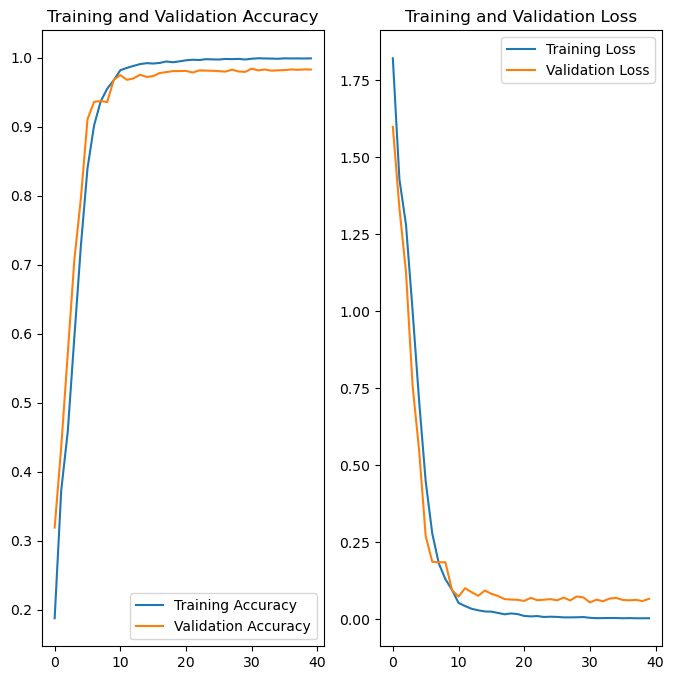

In [75]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [76]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

880/880 [==============================] - 14s 16ms/step
Confusion Matrix
[[1185    6    0    4    0    2]
 [   0 1151    0    0   22    6]
 [   4   20 1129    0    4   15]
 [   0    1    0 1183    1    0]
 [   0   22    0    0 1155    0]
 [   3    4    0    5    3 1113]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.99      0.99      0.99      1197
           Aedes vexans       0.96      0.98      0.97      1179
     Anopheles sinensis       1.00      0.96      0.98      1172
          Culex pipiens       0.99      1.00      1.00      1185
Culex tritaeniorhynchus       0.97      0.98      0.98      1177
            Non vectors       0.98      0.99      0.98      1128

               accuracy                           0.98      7038
              macro avg       0.98      0.98      0.98      7038
           weighted avg       0.98      0.98      0.98      7038

Model is saved in ./models/Model_SDO_Park_2022-09-